# Introduction
This notebook will develop and text GANs for image creation. Specifically, I will use these Generative Adversarial Networks (GANs) to try an create JPEG images that resemble Monet paintings.  
  
Here's the basic idea. We train one network to create an image, this image can be seeded or random. This neural network is called the generator. This notebook will attempt to seed the generator with photos to get interesting results. The next part of the model is the discriminator. The discriminator is trained to identify the real Monet paintings. We input both generated images by the generator, and known Monet painting images, to train the discriminator. The models then work against each other. The generator tries to make more realistic images to fool the discriminator, and the discriminator tries to identify all the fake images. The parameter weights for both of these neural networks get updated as we go.

### Loading our libraries and connecting to Kaggle
I will run this notebook in Google Colab to have access to their GPUs

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import re
import tensorflow as tf
from IPython import display
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import zipfile
import io
from PIL import Image
import time

kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

gan_getting_started_path = kagglehub.competition_download('gan-getting-started')

print('Data source import complete.')


Data source import complete.


In [ ]:
# load the data
data_path = '/root/.cache/kagglehub/competitions/gan-getting-started'
#print(os.listdir(data_path))

# combine the files into one dataset

filelist = [
  '/root/.cache/kagglehub/competitions/gan-getting-started/monet_tfrec/monet12-60.tfrec'
  , '/root/.cache/kagglehub/competitions/gan-getting-started/monet_tfrec/monet16-60.tfrec'
  , '/root/.cache/kagglehub/competitions/gan-getting-started/monet_tfrec/monet08-60.tfrec'
  , '/root/.cache/kagglehub/competitions/gan-getting-started/monet_tfrec/monet04-60.tfrec'
  , '/root/.cache/kagglehub/competitions/gan-getting-started/monet_tfrec/monet00-60.tfrec'
]

training_set = tf.data.TFRecordDataset(filelist)

photolist = [
    '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo00-352.tfrec'
   , '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo01-352.tfrec'
   , '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo02-352.tfrec'
   , '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo03-352.tfrec'
   , '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo04-352.tfrec'
   , '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo05-352.tfrec'
   , '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo06-352.tfrec'
   , '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo07-352.tfrec'
   , '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo08-352.tfrec'
   , '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo09-352.tfrec'
   , '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo10-352.tfrec'
   , '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo11-352.tfrec'
   , '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo12-352.tfrec'
   , '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo13-352.tfrec'
   , '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo14-352.tfrec'
   , '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo15-352.tfrec'
   , '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo16-352.tfrec'
   , '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo17-352.tfrec'
   , '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo18-352.tfrec'
   , '/root/.cache/kagglehub/competitions/gan-getting-started/photo_tfrec/photo19-350.tfrec'
]

photo_set = tf.data.TFRecordDataset(photolist)


## The Data
Kaggle provides the training and seed images for us.
1. 300 Monet paintings sized 256x256 in JPEG format
2. 300 Monet paintings sized 256x256 in TFRecord format
3. 7028 photos sized 256x256 in JPEG format
4. 7028 photos sized 256x256 in TFRecord format

Note that we will only be using the TFRecord format (tfrec). These files are in bindary and optimized for TensorFlow training.
  
Also note that I needed to consult ChatGPT to get these files loaded and reviewed.

## Exploratory Data Analysis
Let's look at some of the Monet images and seeding photos.

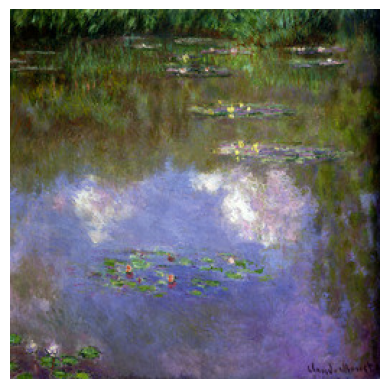

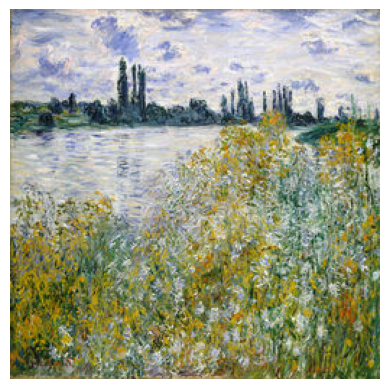

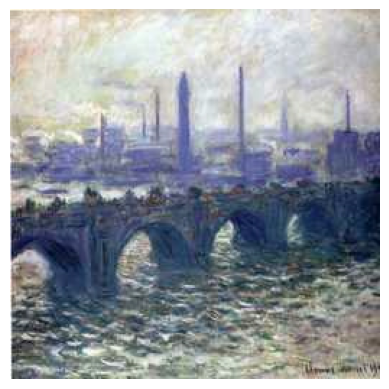

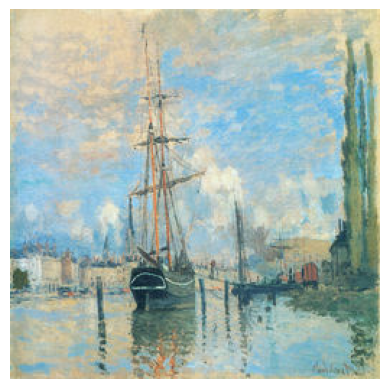

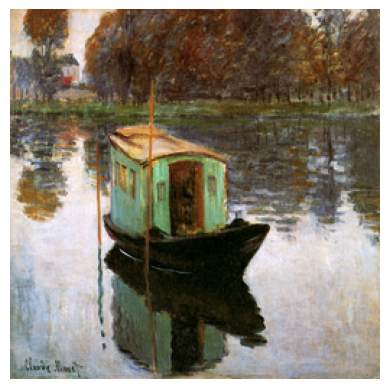

In [ ]:
# inspect the .tfrec files
# I used chat gpt to write the code below

# Define the parsing function
def parse_tfrecord(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),    # specify that we're dealing with images
    }
    example = tf.io.parse_single_example(example, feature_description)   # go one at a time
    image = tf.image.decode_jpeg(example['image'], channels=3)           # color image JPEGs so we know they're (R,G,B)
    image = tf.image.resize(image, [256, 256])         # force size to 256x256
    image = tf.cast(image, tf.float32)                                   # convert to float
    image = (image / 127.5) - 1.0                                        # cleaning step, transform values from 0 to 255 -> -1 to 1
    return image

# create a dataset by using the above function
dataset = training_set.map(parse_tfrecord)

# look at some sample images
dataset = dataset.shuffle(buffer_size=2048)   # shuffle the dataset to get some random paintings

for img in dataset.take(5):
    img = (img + 1.0) / 2.0    # <- convert [-1, 1] back to [0, 1]
    plt.imshow(img.numpy())
    plt.axis('off')
    plt.show()


### Let's also look at some seed photos

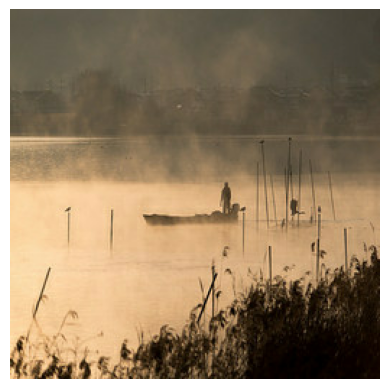

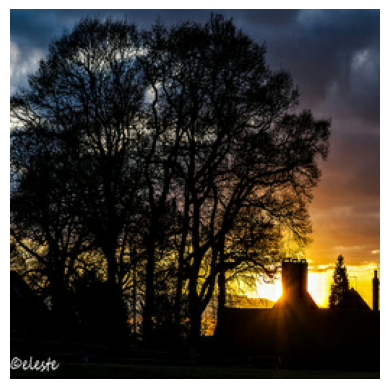

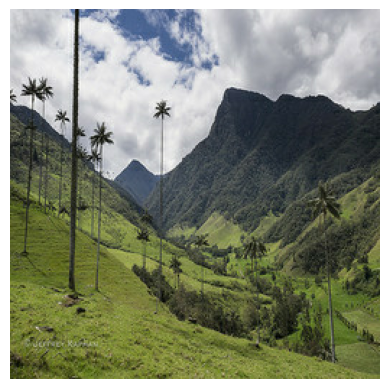

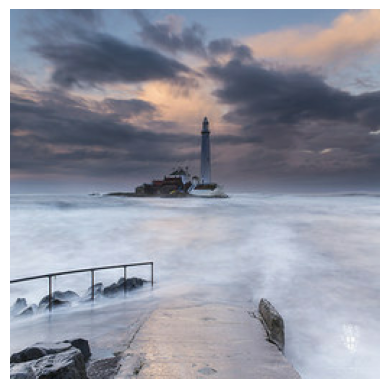

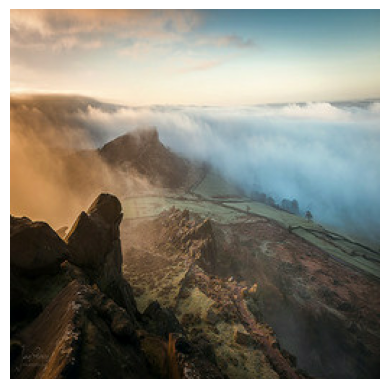

In [ ]:
# photo images

photo_set = photo_set.map(parse_tfrecord)

# look at some sample images
photo_set = photo_set.shuffle(buffer_size=2048)   # shuffle the dataset to get some random paintings

for img in photo_set.take(5):
    img = (img + 1.0) / 2.0    # <- convert [-1, 1] back to [0, 1]
    plt.imshow(img.numpy())
    plt.axis('off')
    plt.show()

## Cleaning
Note that we took care of the cleaning in the parsing function above `parse_tfrecord`  
The main thing we did was to transform the RGB values from 0 to 255, to -1 to 1.   
`image = (image / 127.5) - 1.0 `  
This alows the GAN to learn better. When we have negative values our back propagation becomes more efficient because the gradients will flow in two directions instead of one.

## Modeling
I will start by just using a random seed to do the modeling. Based on the data and our cleaning, I don't think we'll be limited in the early approaches we take. We will start off with a DCGAN model.  
  
The TensorFlow documentation provides a pretty thorough guide for setting up a GAN. I will be following it closely and adjusing the input and output sizes where necessary.
  
The first model I will just make sure I can get working. For the next model, I will adjust the architecture from the tutorial and fine tune the hyperparmeters.
  
### Random Seed

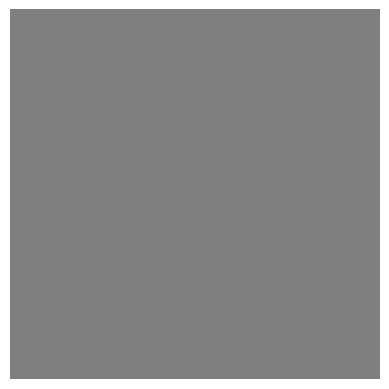

In [ ]:
# random seed model

# used the code from the TF documentation here:
# https://www.tensorflow.org/tutorials/generative/dcgan

# make the generator
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64*64*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((64, 64, 256)))
    assert model.output_shape == (None, 64, 64, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 256, 256, 3)

    return model

# use the generator function to create an image
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

img = (generated_image[0] + 1.0) / 2.0
plt.imshow(img)
plt.axis('off')
plt.show()

### The fact that the noise image is gray makes me a little nervous, but we'll keep going and come back to this if we need to.

### Create the discriminator

In [ ]:
# make the discriminator
def make_discriminator_model():
    model = tf.keras.Sequential()
    tf.keras.Input(shape=(256, 256, 3))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00074668]], shape=(1, 1), dtype=float32)


### Define the loss function

In [ ]:
# define the loss functions

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)   # compare real images to array of 1s
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # compare fake images to array of 0s
    total_loss = real_loss + fake_loss                                  # add the real and fake loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)        # how well did we trick the discriminator



In [ ]:
# optimizers for our first try
generator_optimizer = tf.keras.optimizers.Adam(5e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-4)



### Code for saving checkpoints

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

checkpoint_dir = '/content/drive/MyDrive/gan_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Setup the training loop


In [ ]:
EPOCHS = 250
noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE = 32

# Seed used to generate images for visualization
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Initialize loss history lists
generator_losses = []
discriminator_losses = []

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        gen_loss_epoch = []
        disc_loss_epoch = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch.append(gen_loss)
            disc_loss_epoch.append(disc_loss)

        # Track average loss for the epoch
        avg_gen_loss = tf.reduce_mean(gen_loss_epoch).numpy()
        avg_disc_loss = tf.reduce_mean(disc_loss_epoch).numpy()
        generator_losses.append(avg_gen_loss)
        discriminator_losses.append(avg_disc_loss)

        # Display progress
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 125 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Epoch {epoch+1}, Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}')
        print('Time for epoch {} is {:.2f} sec'.format(epoch + 1, time.time() - start))

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1.0) / 2.0  # Scale from [-1,1] to [0,1]

    fig = plt.figure(figsize=(8, 8))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))   # don't think I need to save all these, they take up a lot of space
    plt.show()


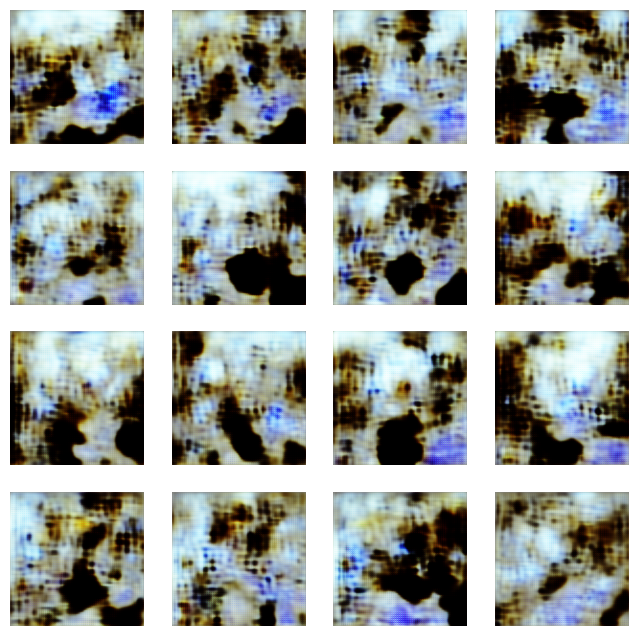

In [ ]:
# try the training
BATCH_SIZE = 32
dataset = dataset.batch(BATCH_SIZE)
train(dataset, EPOCHS)

### They look like nonsense, but at least it's Monet adjacent nonsense.

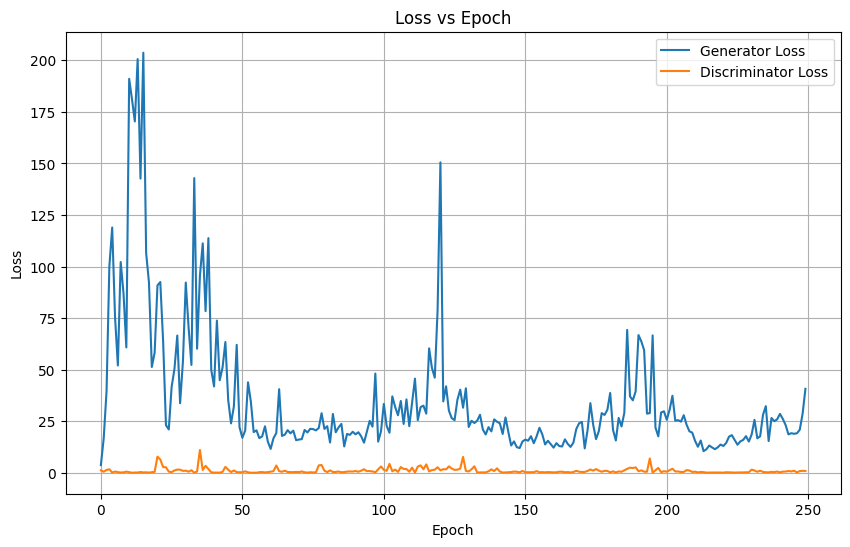

In [ ]:
# plot the loss
plt.figure(figsize=(10, 6))
plt.plot(generator_losses, label='Generator Loss')
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
output_zip_path = 'generated_images.zip'
num_images = 7000
noise_dim = 100
batch_size = 32

with zipfile.ZipFile(output_zip_path, mode='w', compression=zipfile.ZIP_DEFLATED) as zf:
    img_id = 0
    while img_id < num_images:
        # Generate a batch of images
        current_batch_size = min(batch_size, num_images - img_id)
        noise = tf.random.normal([current_batch_size, noise_dim])
        generated_batch = generator(noise, training=False)

        # Scale from [-1, 1] to [0, 255]
        generated_batch = (generated_batch + 1.0) / 2.0
        generated_batch = tf.clip_by_value(generated_batch, 0.0, 1.0)
        generated_batch = tf.image.convert_image_dtype(generated_batch, dtype=tf.uint8)

        for i in range(current_batch_size):
            img_tensor = generated_batch[i].numpy()
            img_pil = Image.fromarray(img_tensor)

            # Save image to an in-memory buffer
            buffer = io.BytesIO()
            img_pil.save(buffer, format='JPEG')
            buffer.seek(0)

            # Write to zip file
            filename = f"image_{img_id:05d}.jpg"
            zf.writestr(filename, buffer.read())
            img_id += 1

print(f"{num_images} images saved to {output_zip_path}")

7000 images saved to generated_images.zip


In [ ]:
from google.colab import files
files.download('generated_images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Initial Analysis
The images somewhat resemble Monet paintings. That's amazing considering we start with just random noise. When evaluating the generator and discriminator loss, the generator loss is much higher, but that's because the discriminator loss is only checking for one or zero, so it's absolute magnitude won't be very high. We need to see where they're both relatively low and this seems to happen at around 150 epochs.

### Based on recommendations from the paper Improved Techniques for Training GANs, I will be making a few modifications for the next model.
1. Add Label Smoothing
2. Use Dropout in the Generator
3. Add Gaussian Noise to Discriminator Inputs

In [ ]:
# new generator with dropout

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64*64*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))   # adding dropout layer

    model.add(layers.Reshape((64, 64, 256)))
    assert model.output_shape == (None, 64, 64, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))   # adding dropout layer

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))   # adding dropout layer

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 256, 256, 3)

    return model

### Updated Training Block


In [ ]:
# optimizers stay the same
generator_optimizer = tf.keras.optimizers.Adam(5e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-4)

# other hyperparameters
EPOCHS = 250
noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE = 32

# Seed used to generate images for visualization
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Initialize loss history lists
generator_losses = []
discriminator_losses = []

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        # add noise
        noise_factor = 0.1   # can increase this if I want more noise
        images = images + noise_factor * tf.random.normal(tf.shape(images))
        generated_images = generated_images + noise_factor * tf.random.normal(tf.shape(generated_images))

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # add label smoothing
        # pulled from chat gpt
        real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

### Try training on the new model


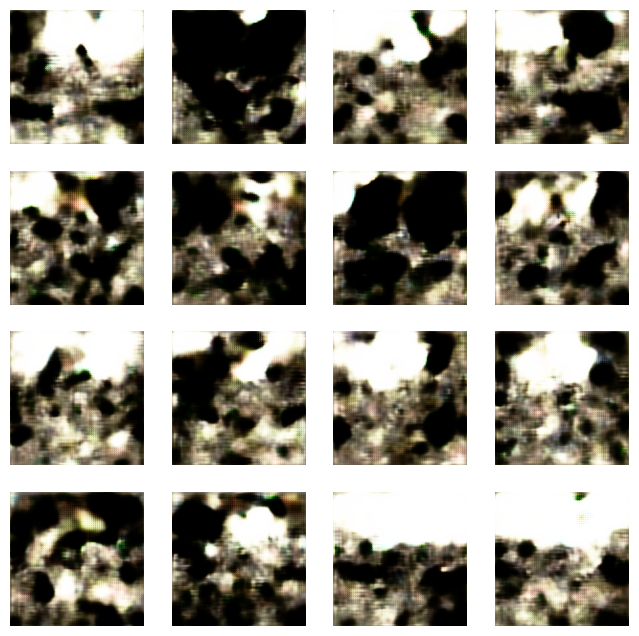

In [ ]:
# try the training
BATCH_SIZE = 32
dataset = dataset.batch(BATCH_SIZE)
train(dataset, EPOCHS)

### I feel like our first pass was better. Let's take a look at the loss.

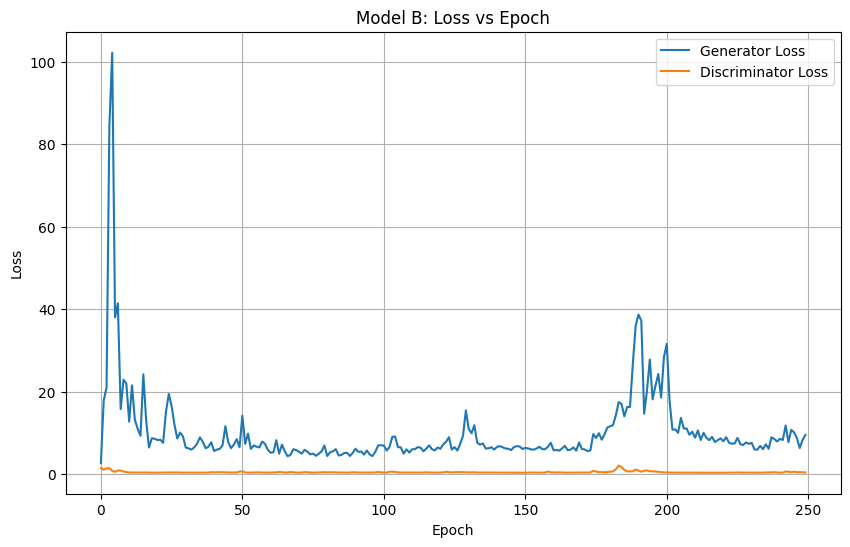

In [ ]:
# plot the loss
plt.figure(figsize=(10, 6))
plt.plot(generator_losses, label='Generator Loss')
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model B: Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

### There was definitely a generator loss improvement. It improved quite a lot acutually and looks more stable. For the next model I will do a little more hyperparameter tuning. I will decrease the dropout rates a bit and also decrease the learning rate.

In [ ]:
# new generator with dropout changed to 0.15

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64*64*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.15))   # adding dropout layer

    model.add(layers.Reshape((64, 64, 256)))
    assert model.output_shape == (None, 64, 64, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.15))   # adding dropout layer

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.15))   # adding dropout layer

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 256, 256, 3)

    return model

In [ ]:
# optimizers decreased to .0001
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# other hyperparameters
EPOCHS = 250
noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE = 32

# Seed used to generate images for visualization
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Initialize loss history lists
generator_losses = []
discriminator_losses = []

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        # add noise
        noise_factor = 0.1   # can increase this if I want more noise
        images = images + noise_factor * tf.random.normal(tf.shape(images))
        generated_images = generated_images + noise_factor * tf.random.normal(tf.shape(generated_images))

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # add label smoothing
        # pulled from chat gpt
        real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

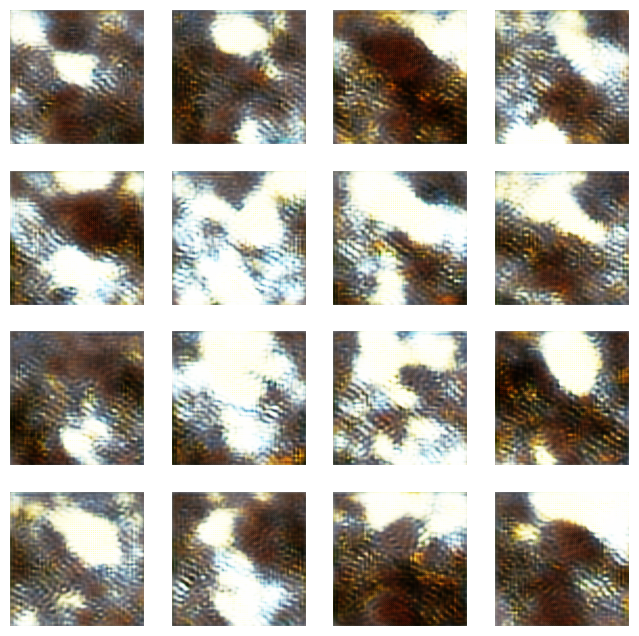

In [ ]:
# try the training
BATCH_SIZE = 32
dataset = dataset.batch(BATCH_SIZE)
train(dataset, EPOCHS)

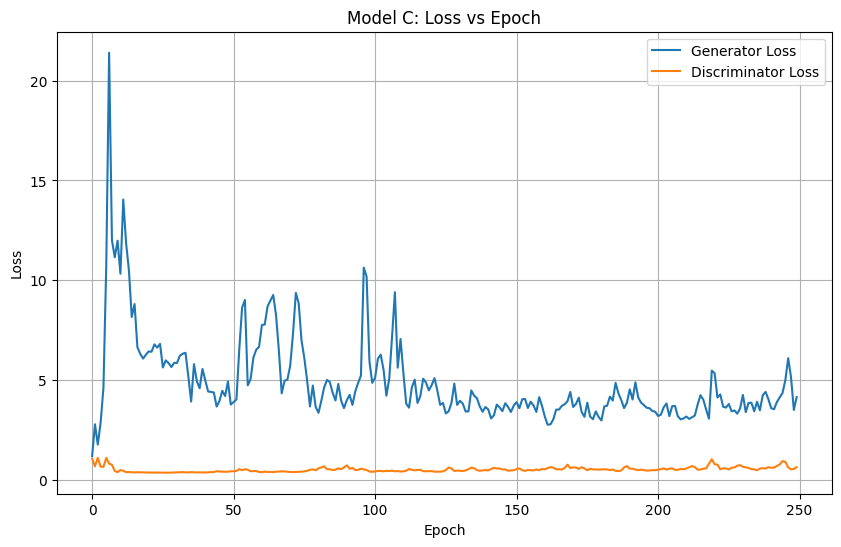

In [ ]:
# plot the loss
plt.figure(figsize=(10, 6))
plt.plot(generator_losses, label='Generator Loss')
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model C: Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

### The generator loss keeps improving, but the images don't seem to represent what we're trying to capture. We can definitely see the impressionist elements, but we're missing some color variation. Let's try one more model with another layer added to the discriminator.

In [ ]:
# new discriminator

def make_discriminator_model():
    model = tf.keras.Sequential()
    tf.keras.Input(shape=(256, 256, 3))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))   # added another layer of convolution and changed to 3x3 matrix
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))



    return model


### The rest of our setup will be the same from model C

In [ ]:
# same generator as last time
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# other hyperparameters
EPOCHS = 250
noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE = 32

# Seed used to generate images for visualization
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Initialize loss history lists
generator_losses = []
discriminator_losses = []

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        # add noise
        noise_factor = 0.1   # can increase this if I want more noise
        images = images + noise_factor * tf.random.normal(tf.shape(images))
        generated_images = generated_images + noise_factor * tf.random.normal(tf.shape(generated_images))

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # add label smoothing
        # pulled from chat gpt
        real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

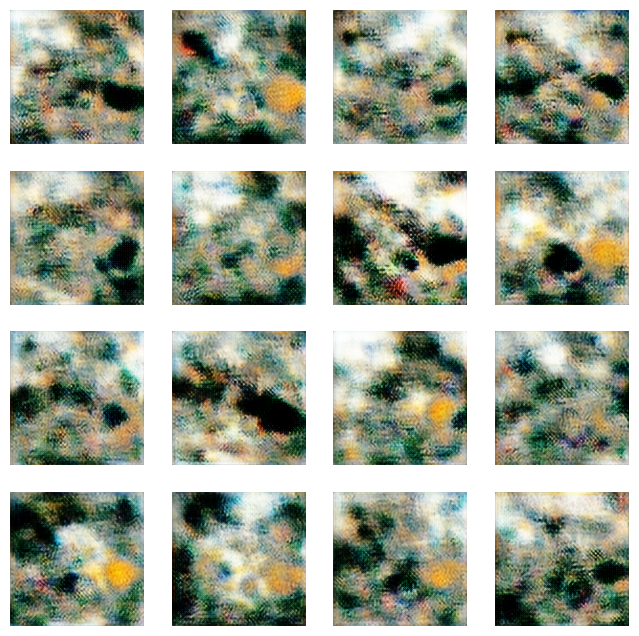

In [ ]:
BATCH_SIZE = 32
dataset = dataset.batch(BATCH_SIZE)
train(dataset, EPOCHS)

### I think this is our best result yet! Still captured the impressionist elements but with more color too.

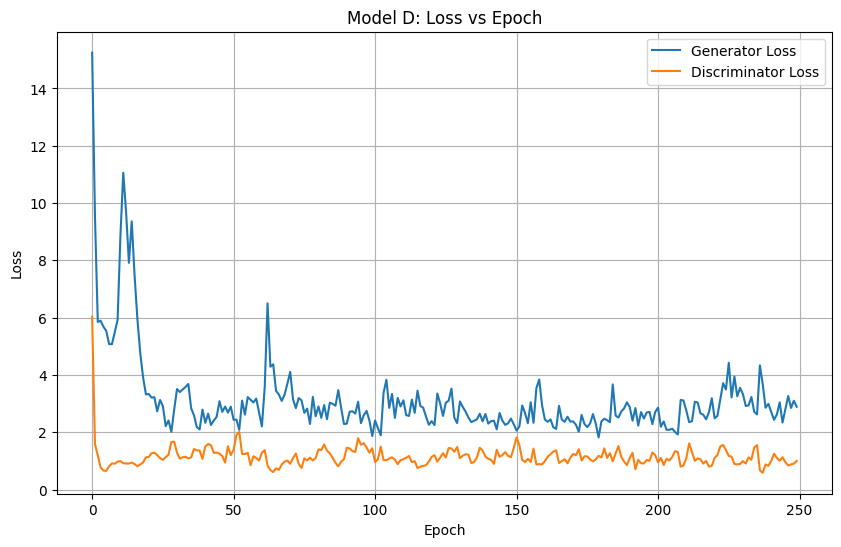

In [ ]:
# plot the loss
plt.figure(figsize=(10, 6))
plt.plot(generator_losses, label='Generator Loss')
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model D: Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

## Results and Analysis  
In order to analyze our results let's review the generated images for each model and their loss values over training epochs.  

Model A, our initial model, does a decent job generating images that look kind of like a Monet painting. When we review the loss plots, we see that while the generator loss improves as we go through epochs, it still has room for improvement. The discriminator loss is much lower, but because of the scale of the plot it's difficult to see how close to zero it is. We don't want it to be too good or it won't allow the generator to imrove.  
  
For Model B we added some improvements to the model; label smoothing, dropout layers to the generator, and introduced Gaussian noise. The images don't look very good. For the loss plots, the generator does improve again, but the discriminator looks too close to zero. We probably should have addressed that in our next model but I didn't do it until Model D.

The Model C images are interesting. In this model I reduced the dropout rates and reduced the learning rate. It seems like the generator really focused on the impressionist 'dot' effect found in Monet's paintings. Too much so in fact; the images have a shimmering quality like looking at a surface of water. The loss plots here look even better. I'm satisfied with how the generator loss looks, so let's see if we can modify the discriminator loss.

I think the final model, model D, most resembles a Monet painting. For this model I enhanced the discriminator function by adding another convolution layer and using a finer convolution matrix, 3x3 instead of 5x5. Our generator loss looks better than ever, but at the expense of the discriminator loss, but that's ok, we want the discriminator to be wrong sometimes too.

## Conclusion
This was a very interesting project. The coding was quite complex all the way from the input files used to the algorithms we combined to create this DCGAN.  
  
The complexity of the code required me to lean quite heavily on TensorFlow and Keras documentation, as well as often consulting ChatGPT for debugging advice and solutions.  
  
My primary take away from this project is that it's very important to make sure your generator and discriminator functions are balanced. In my first models, I only focused on improving the generator. While this did lower our generator loss, we weren't seeing more Monet-like images generated. When I finally took the time to adjust the discriminator part of the model, that's when we got the best results.  
  
For future work, I would be interested in using an architecture like Conditional GANs. Those models allow the generator and discriminator to be conditioned on a third image. That way, we could introduce an image like a sailboat or garden to try and generate a Monet like image of those objects.  
  
Unfortunately, I was unable to submit the file for competition grading. I couldn't get the GPUs enabled in Kaggle.